In [24]:
from vega import Vega
import json
import altair as alt

import pandas as pd
artefacts_df = pd.read_csv("records-institution-stats-type.csv")
artefacts_non_nature_df = artefacts_df.loc[artefacts_df['topic'] != 'nature']
artefacts_museum_df = artefacts_df.loc[artefacts_df['type'] == 'museum']

# Overview

*WORK IN PROGRESS - Updated Aug 2024*

In [25]:
from collections import Counter

tree_totals = artefacts_df.groupby('type').sum(numeric_only=True)
tree_structure = [ { "id": 1, "name": "National Collection" } ]
tree_node_index = 2
#tree_totals.columns
parent_map = {}
for row in tree_totals.iterrows():
  parent_map[row[0]] = tree_node_index
  tree_structure.append({"id": tree_node_index, "name": row[0], 
                         "parent": 1})
  tree_node_index+= 1


institution_type_index = Counter()
for i, row in artefacts_df.iterrows():
    tree_structure.append({"id": tree_node_index, "name": row["institution"], 
                           "size": int(row["record_count"]), 
                         "parent": parent_map[row['type']]})
    institution_type_index[row["type"]] += 1
    tree_node_index+=1

In [26]:
treemap_test_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 600,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }},
    {{
      "name": "large-leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children && datum.size > 2500000"}}]
    }},
    {{
      "name": "total",
      "source": "tree",
      "transform": [{{"type": "aggregate", "fields": ["size"], "ops": ["sum"], "as": ["totalsize"]}}]
      }},
  {{
      "name": "percentages",
      "source": "tree",
      "transform":  [
      {{ "type": "lookup","from": "total","key": "id","fields": ["totalsize"],"values": ["totalsize"]   }},
      {{"type": "formula", "expr": "datum.name + ' ' + format((datum.size/datum.totalsize), ',.1%')", "as": "nc_percent"}}
      ]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0, 0]
    }},
    {{
      "name": "collection-size",
      "type": "quantile",
      "domain": [0, 1000, 10000, 100000, 1000000, 2500000, 5000000, 20000000],
      "range": [0, 0, 7, 12, 14, 16, 18, 20]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0.8, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }},  
    {{
      "type": "text",
      "from": {{"data": "percentages"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "collection-size", "field": "size"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.46 * (datum.y0 + datum.y1)"}},
          "text": {{"signal": "split(datum.nc_percent, ' ')"}}
        }}
      }}
    }}
  ]
}}
"""

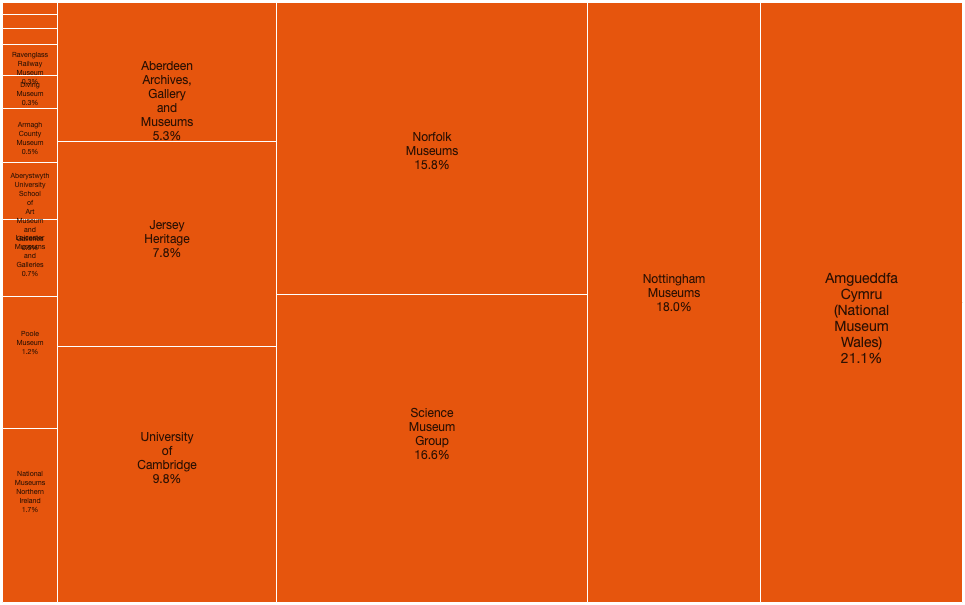

In [27]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(treemap_test_spec)}, 
         metadata={
    "application/vnd.vegalite.v5+json": {
        "embed_options": {
            "actions": True
        }
    }
},  raw=True)

In [7]:
from collections import Counter

nn_tree_totals = artefacts_non_nature_df.groupby('type').sum(numeric_only=True)
nn_tree_structure = [ { "id": 1, "name": "National Collection" } ]
nn_tree_node_index = 2
#tree_totals.columns
nn_parent_map = {}
for nn_row in nn_tree_totals.iterrows():
  nn_parent_map[nn_row[0]] = nn_tree_node_index
  nn_tree_structure.append({"id": nn_tree_node_index, "name": nn_row[0], 
                         "parent": 1})
  nn_tree_node_index+= 1


nn_institution_type_index = Counter()
for nn_i, nn_row in artefacts_non_nature_df.iterrows():
    nn_tree_structure.append({"id": nn_tree_node_index, "name": nn_row["institution"], 
                           "size": int(nn_row["record_count"]), 
                         "parent": nn_parent_map[nn_row['type']]})
    nn_institution_type_index[nn_row["type"]] += 1
    nn_tree_node_index+=1

In [16]:
nn_treemap_test_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 500,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(nn_tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }},
    {{
      "name": "total",
      "source": "tree",
      "transform": [{{"type": "aggregate", "fields": ["size"], "ops": ["sum"], "as": ["totalsize"]}}]
      }},
  {{
      "name": "percentages",
      "source": "tree",
      "transform":  [
      {{"type": "formula", 
      "expr": "datum.name", "as": "nc_percent"}}
      ]
    }},
    {{
      "name": "large-leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children && datum.size > 2500000"}}]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 20, 18, 14]
    }},
    {{
      "name": "collection-size",
      "type": "quantile",
      "domain": [0, 100, 10000, 100000, 1000000, 2500000, 5000000, 20000000],
      "range": [2, 4, 7, 12, 14, 16, 18, 20]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0.6, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }},  
    {{
      "type": "text",
      "from": {{"data": "percentages"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "collection-size", "field": "size"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.46 * (datum.y0 + datum.y1)"}},
          "text": {{"signal": "split(datum.nc_percent, ' ')"}}
        }}
      }}
    }}
  ]
}}
"""

#### National Collection Overview (excluding specimen holding organisations)

The scale of collections held by natural history holding organisations can overwhelm data visualisations of overall UK collections, so in this area chart below they have been removed to allow more visibility of other collections.

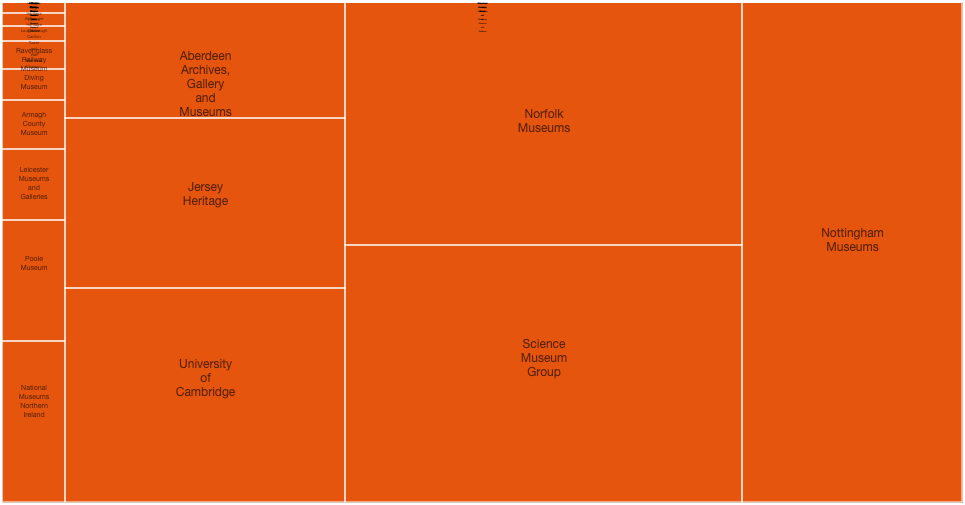

In [17]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(nn_treemap_test_spec)}, 
        metadata={
    "application/vnd.vegalite.v5+json": {
        "embed_options": {
            "actions": False,
            "hover": True
        }
    }
},   raw=True)